In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats

In [13]:
def simulate_data(T, alpha, beta, gamma, theta):
    np.random.seed(123)
    X = np.zeros(T)
    Y = np.zeros(T)

    # Generate X values from N(0, 1)
    X[0] = np.random.normal(0, 1)

    epsilon_t = np.random.randn()
    epsilon_t_lag = np.roll(epsilon_t, 1)
    # Generate Y values
    for t in range(1, T):
        #epsilon_t = np.random.randn()
        #epsilon_t_lag = np.roll(epsilon_t, 1)
        X[t] = np.random.normal(0, 1)
        Y[t] = alpha + beta * Y[t - 1] + gamma * X[t] + epsilon_t + theta * epsilon_t_lag

    return pd.DataFrame({'X': X, 'Y': Y})

# Set the parameters for each quantile level
quantiles = [0.1, 0.5, 0.9]
parameters = {
    0.1: {'alpha': -1.2, 'beta': 0.3, 'gamma': 0.2, 'theta': 0.9},
    0.5: {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3, 'theta': 0.9},
    0.9: {'alpha': 1.2, 'beta': 0.7, 'gamma': 0.4, 'theta': 0.9}}
    
T = 334

df = pd.DataFrame()

# Simulate data for each quantile level and concatenate into a single DataFrame
for quantile in quantiles:
    params = parameters[quantile]
    data = simulate_data(T, params['alpha'], params['beta'], params['gamma'], params['theta'])
    df = pd.concat([df, data], ignore_index=True)
print(df)


             X          Y
0    -1.085631   0.000000
1     0.282978   0.751552
2    -1.506295   0.619163
3    -0.578600   0.764985
4     1.651437   1.254739
...        ...        ...
997  -0.145364  10.045232
998   1.868726  10.874109
999  -0.518704  10.499351
1000 -0.062399  10.419543
1001 -0.102911  10.347472

[1002 rows x 2 columns]


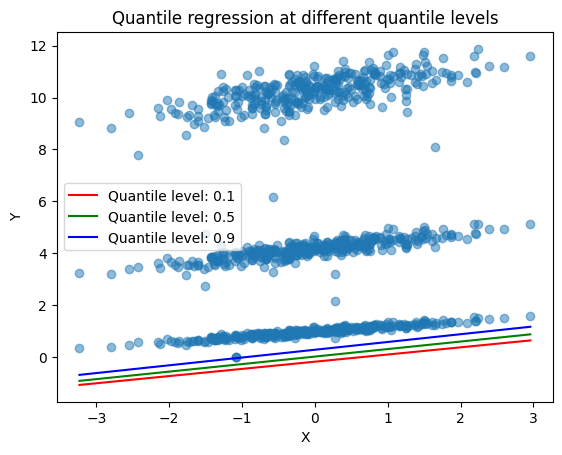

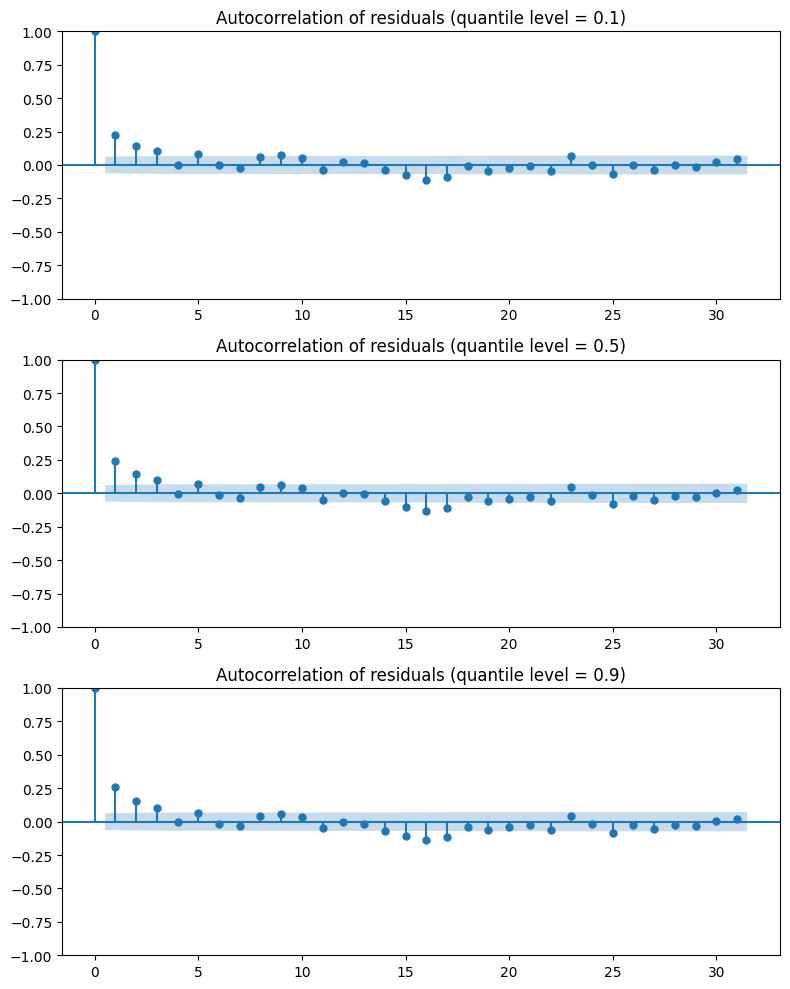

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.9164
 Model:                       QuantReg   Bandwidth:                     0.07845
 Method:                 Least Squares   Sparsity:                       0.9561
 Date:                Sat, 01 Jul 2023   No. Observations:                 1002
 Time:                        16:47:45   Df Residuals:                      999
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -0.1769      0.016    -11.405      0.000      -0.207      -0.146
 x1             0.9904      0.002    407.229      0.000       0.986       0.995
 x2             0.2769      0.010     26.761      0.000       0.257   

In [14]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['Y'].values.astype(float)
    x = df['X'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 250)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

fit_quantile(df)

In [10]:
actuals1 = np.array([-0.2, 0.3, 0.2])
actuals5 = np.array([0.2, 0.5, 0.3])
actuals9 = np.array([0.6, 0.7, 0.4])
beta_pac1 = np.array([-0.1308, 0.9813, 0.2733])  
beta_pac5 = np.array([0.0524, 0.9896, 0.2923])  
beta_pac9 = np.array([0.3399, 0.9871, 0.3131])    # True parameters alpha, beta, gamma, theta
  # Calculate the biases
biases_ols = actuals1 - np.array(beta_pac1)
for i, bias in enumerate(biases_ols):
    print(f"OLS_bias_param_{i} = {bias:.4f}")
    
mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
rmse_ols = np.sqrt(mse_ols)
print(f"OLS_RMSE = {rmse_ols:.4f}")
    
biases_gls = actuals5 - np.array(beta_pac5) # Calculate the biases
for i, bias in enumerate(biases_gls):
    print(f"GLS_bias_param_{i} = {bias:.4f}")
    
mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
rmse_gls = np.sqrt(mse_gls)
print(f"GLS_RMSE = {rmse_gls:.4f}")

biases_gls = actuals9 - np.array(beta_pac9) # Calculate the biases
for i, bias in enumerate(biases_gls):
    print(f"GLS_bias_param_{i} = {bias:.4f}")
    
mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
rmse_gls = np.sqrt(mse_gls)
print(f"GLS_RMSE = {rmse_gls:.4f}")

OLS_bias_param_0 = -0.0692
OLS_bias_param_1 = -0.6813
OLS_bias_param_2 = -0.0733
OLS_RMSE = 0.3976
GLS_bias_param_0 = 0.1476
GLS_bias_param_1 = -0.4896
GLS_bias_param_2 = 0.0077
GLS_RMSE = 0.2953
GLS_bias_param_0 = 0.2601
GLS_bias_param_1 = -0.2871
GLS_bias_param_2 = 0.0869
GLS_RMSE = 0.2292
